Connecting with google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


Imports

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.metrics import MeanIoU

Loading the data

In [3]:
directory_path = '/content/drive/MyDrive/TumorS'

image_files = sorted([os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

TumorS = []

for image_file in image_files:
    image = cv2.imread(image_file)
    if image is not None:
        TumorS.append(image)
    else:
        print(f"Failed to read image: {image_file}")

print(len(TumorS))


1000


In [4]:
directory_path = '/content/drive/MyDrive/Maske'

image_files = sorted([os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

Masks = []

for image_file in image_files:
    image = cv2.imread(image_file)
    if image is not None:
        Masks.append(image)
    else:
        print(f"Failed to read image: {image_file}")

print(len(Masks))


1000


Showing the data

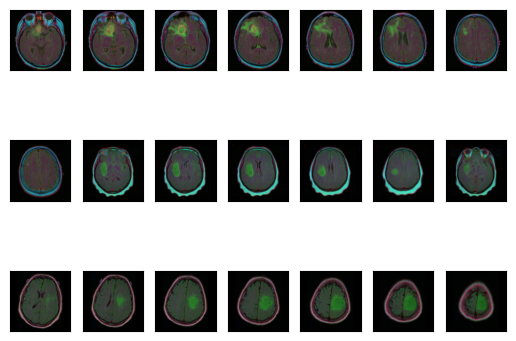

In [8]:
fig, ax = plt.subplots(3, 7)
for i, axi in enumerate(ax.flat):
    axi.imshow(TumorS[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

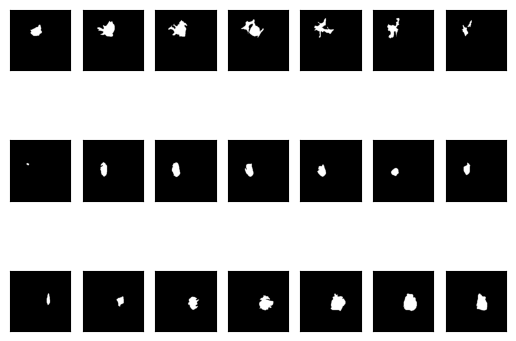

In [9]:
fig, ax = plt.subplots(3, 7)
for i, axi in enumerate(ax.flat):
    axi.imshow(Masks[i], cmap='bone')
    axi.set(xticks=[], yticks=[])

Pre-processing the data

In [5]:
def preprocess_images(images, size=(256, 256)):
    preprocessed_images = []
    for img in images:
        img_resized = cv2.resize(img, size)
        img_normalized = img_resized / 255.0
        preprocessed_images.append(img_normalized)
    return np.array(preprocessed_images)

def preprocess_masks(masks, size=(256, 256)):
    preprocessed_masks = []
    for mask in masks:
        mask_resized = cv2.resize(mask, size)
        mask_gray = cv2.cvtColor(mask_resized, cv2.COLOR_BGR2GRAY)
        mask_binary = np.where(mask_gray > 0, 1, 0)
        preprocessed_masks.append(mask_binary)
    return np.array(preprocessed_masks)

tumorS = preprocess_images(TumorS)
masks = preprocess_masks(Masks)

Defining model architecture

In [6]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

model = unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=2)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

Splitting the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tumorS, masks, test_size=0.2, random_state=42)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

Training the model

In [8]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 93s 926ms/step - loss: 0.3531 - accuracy: 0.9622 - mean_io_u: 0.4826 - val_loss: 0.0866 - val_accuracy: 0.9661 - val_mean_io_u: 0.4831
Epoch 2/10
50/50 [==============================] - 40s 810ms/step - loss: 0.0746 - accuracy: 0.9672 - mean_io_u: 0.4826 - val_loss: 0.0602 - val_accuracy: 0.9793 - val_mean_io_u: 0.4831
Epoch 3/10
50/50 [==============================] - 41s 816ms/step - loss: 0.0664 - accuracy: 0.9772 - mean_io_u: 0.4826 - val_loss: 0.0670 - val_accuracy: 0.9757 - val_mean_io_u: 0.4831
Epoch 4/10
50/50 [==============================] - 39s 780ms/step - loss: 0.0618 - accuracy: 0.9781 - mean_io_u: 0.4826 - val_loss: 0.0501 - val_accuracy: 0.9821 - val_mean_io_u: 0.4831
Epoch 5/10
50/50 [==============================] - 41s 827ms/step - loss: 0.0594 - accuracy: 0.9790 - mean_io_u: 0.4826 - val_loss: 0.0500 - val_accuracy: 0.9818 - val_mean_io_u: 0.4831
Epoch 6/10
50/50 [==============================] - 41s 826ms/ste

Evaluation

In [9]:
loss, accuracy, mean_iou = model.evaluate(X_test, y_test)

7/7 [==============================] - 22s 426ms/step - loss: 0.0288 - accuracy: 0.9889 - mean_io_u: 0.4831


Graphic prediction

7/7 [==============================] - 3s 453ms/step


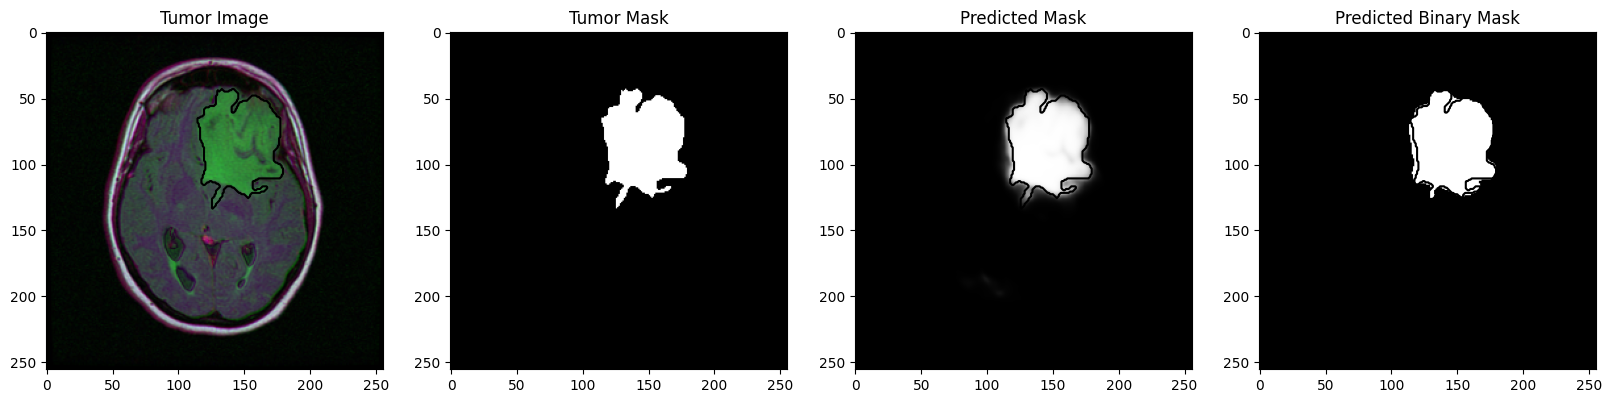

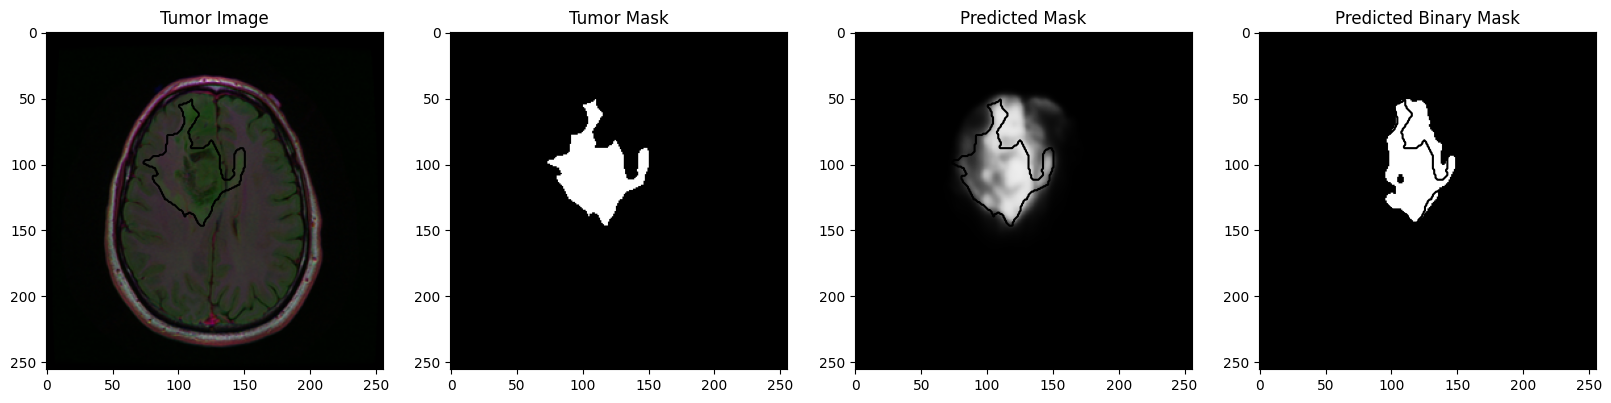

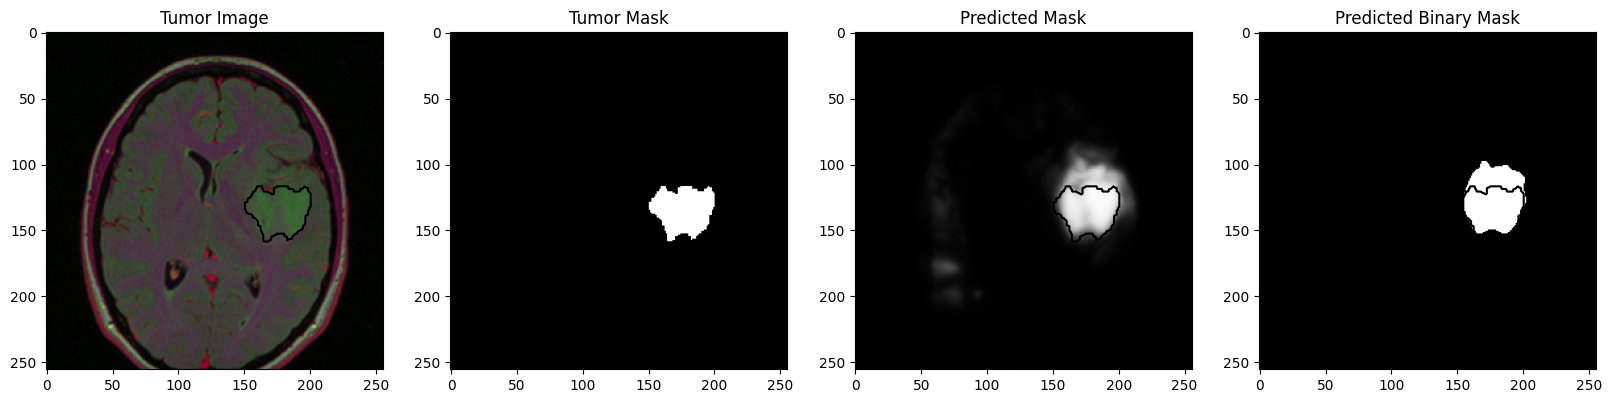

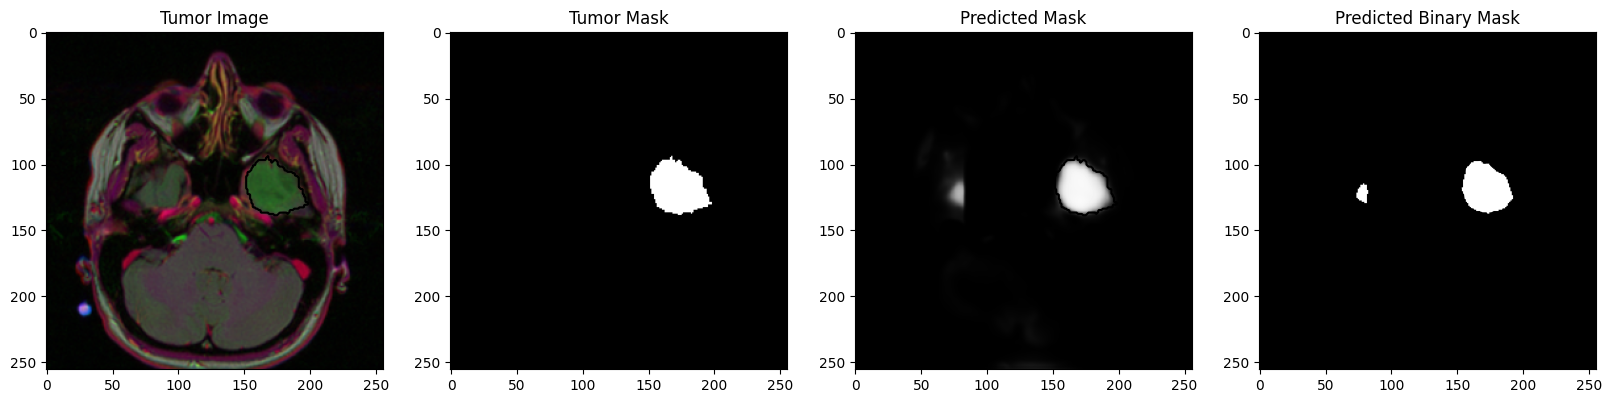

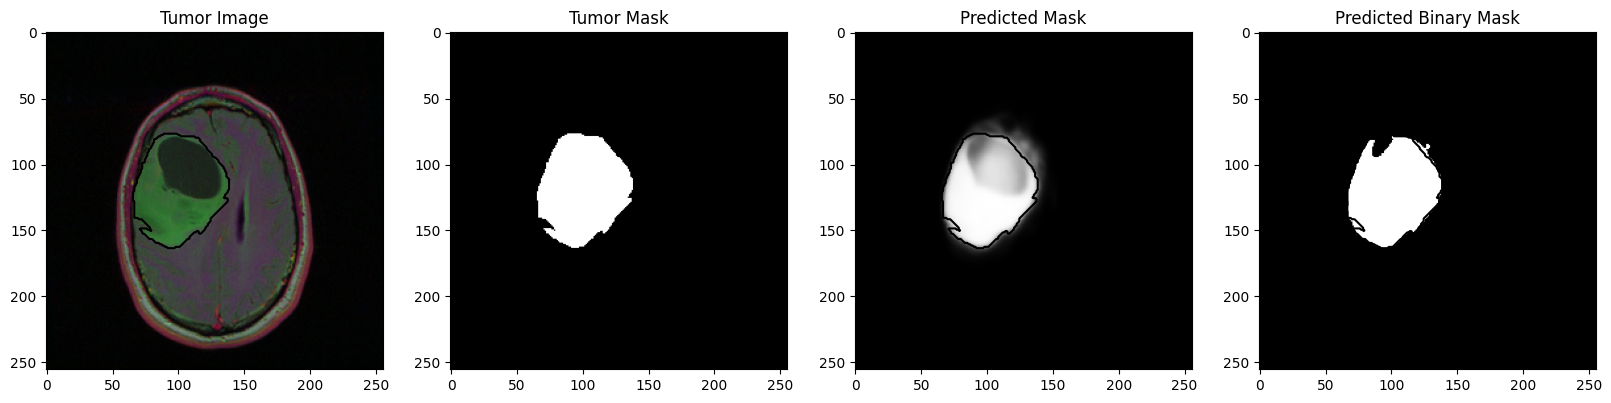

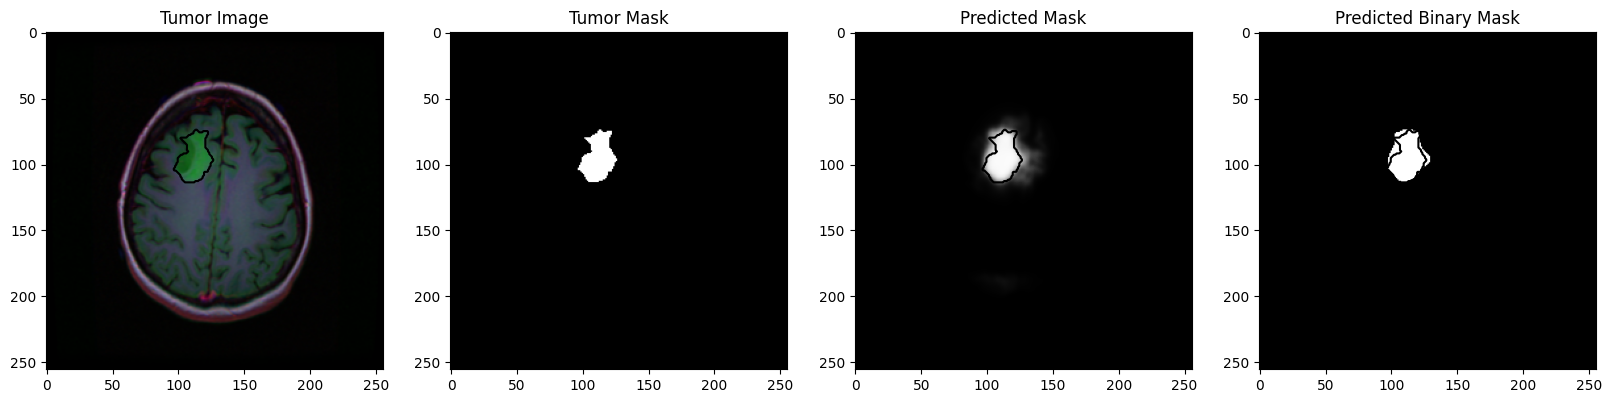

In [10]:
preds = model.predict(X_test)
binary_preds = (preds > 0.5).astype(np.uint8)
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tumor Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Tumor Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Binary Mask')

    plt.show()

plot_sample(X_test, y_test, preds, binary_preds)
for i in range(5):
    plot_sample(X_test, y_test, preds, binary_preds, ix=i)
